# Deep Learning and Neural Network - Question 2
## Arian Firoozi - 810100196
## Arman Majidi - 810100205

# Outline
- [ 0 - Packages ](#0)
- [ 1 - Preparation ](#1)
- [ 2 - Generating Adversarial Pictures ](#2)
- [ 3 - Model Implementation ](#3)

---

<a name="0"></a>
## 0 - Packages 

First, let's run the cell below to import all the packages.
- [numpy](https://numpy.org) is the fundamental package for working with matrices in Python.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [seanborn](https://seaborn.pydata.org) is a Python data visualization library based on matplotlib.
- [tensorflow](https://tensorflow.org) is an end-to-end platform for machine learning.
- [pytorch](https://pytorch.org) PyTorch is a machine learning library based on the Torch library.
- [cleverhans](https://cleverhans-lab.github.io/) is a Python library to benchmark machine learning systems' vulnerability to adversarial examples.

In [1]:
!pip install cleverhans

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
import torch.nn as nn
import torch.optim as optim

np.random.seed(24)

---

<a name="1"></a>
## 1 - Preparation

### ◆ Functions

#### unnormalize

In [3]:
def unnormalize(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

#### showing random pictures

In [4]:
def show_random_samples(dataset, class_names):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for ax in axes:
        idx = np.random.randint(0, len(dataset))
        img, label = dataset[idx]
        np_img = unnormalize(img)
        ax.imshow(np_img)
        ax.set_title(class_names[label])
        ax.axis('off')
    plt.show()

#### model evaluation

In [5]:
def evaluate_model_accuracy(model, loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
dataset = datasets.CIFAR10(root='./dataset', train=True, download=True, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

100%|██████████| 170498071/170498071 [00:03<00:00, 43217253.93it/s]


Extracting ./dataset/cifar-10-python.tar.gz to ./dataset


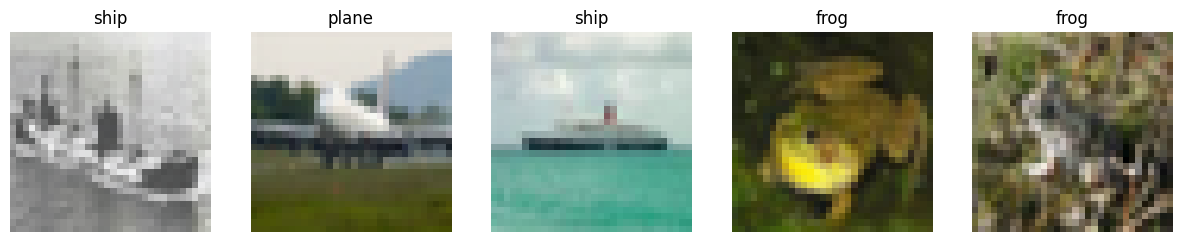

In [7]:
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
show_random_samples(train_dataset, class_names)

In [8]:
target_model = torch.hub.load("chenyaofo/pytorch-cifar-models",
"cifar10_resnet20", pretrained=True)
target_model.eval()

/usr/local/lib/python3.10/dist-packages/torch/hub.py:295: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet20-4118986f.pt" to /root/.cache/torch/hub/checkpoints/cifar10_resnet20-4118986f.pt
100%|██████████| 1.09M/1.09M [00:00<00:00, 29.4MB/s

CifarResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

In [9]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
test_accuracy = evaluate_model_accuracy(target_model, test_loader)
print(f"Model Test Accuracy: {test_accuracy:.2%}")

Model Test Accuracy: 99.92%


---

<a name="2"></a>
## 2 - Generating Adversarial Pictures

### ◆ Functions

#### adversarial generation function

In [10]:
def generate_adversarial(model, loader, epsilon=0.01):
    correct = 0
    total = 0
    successful_attacks = 0
    original_images, adversarial_images, perturbations = [], [], []
    for images, labels in loader:
        images.requires_grad = True        
        adv_images = fast_gradient_method(model, images, epsilon, np.inf)        
        outputs_original = model(images)
        outputs_adv = model(adv_images)
        _, predicted_original = torch.max(outputs_original.data, 1)
        _, predicted_adv = torch.max(outputs_adv.data, 1)
        total += labels.size(0)
        correct += (predicted_original == labels).sum().item()
        successful_attacks += (predicted_adv != labels).sum().item()
        if len(original_images) < 5:
            original_images.extend(images[:5].detach())
            adversarial_images.extend(adv_images[:5].detach())
            perturbations.extend((adv_images[:5] - images[:5]).detach().abs())
    attack_success_rate = successful_attacks / total
    print(f"Attack Success Rate: {attack_success_rate:.2%}")
    return original_images, adversarial_images, perturbations

In [11]:
original_images, adversarial_images, perturbations = generate_adversarial(target_model, test_loader)

Attack Success Rate: 31.86%


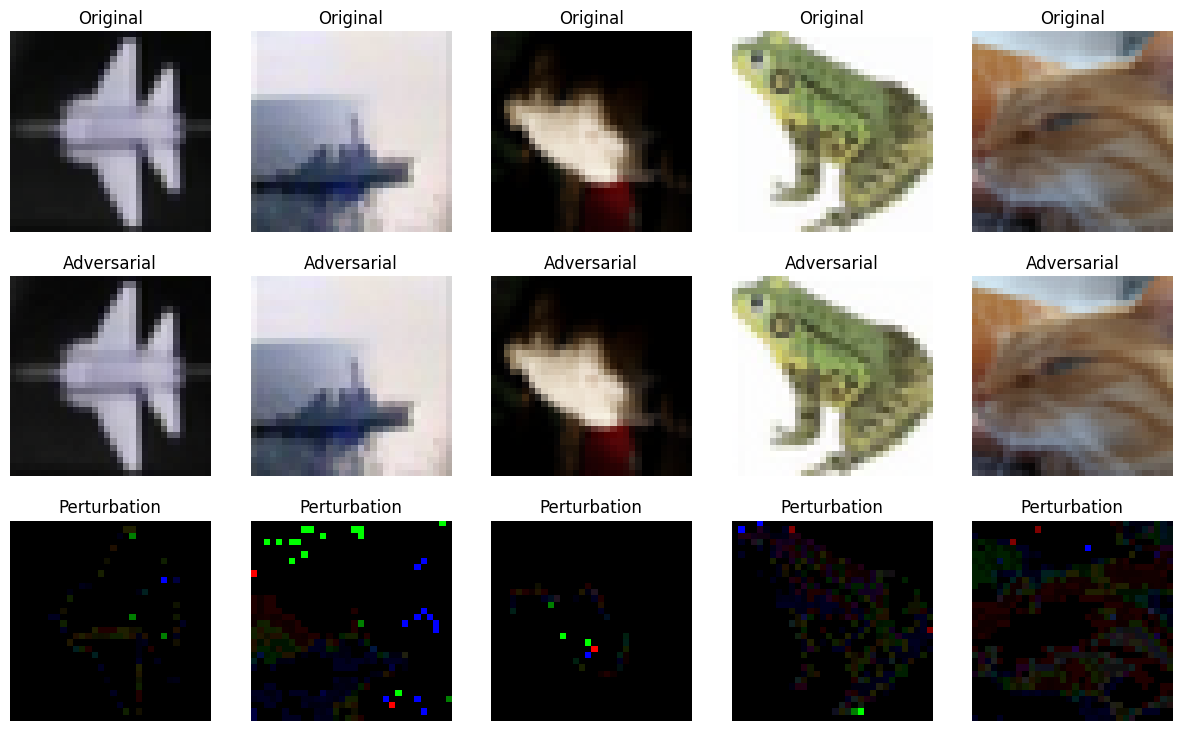

In [12]:
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
for i in range(5):
    original = unnormalize(original_images[i])
    axes[0, i].imshow(original)
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")        
    
    adv = unnormalize(adversarial_images[i],)
    axes[1, i].imshow(adv)
    axes[1, i].axis('off')
    axes[1, i].set_title("Adversarial")
    
    perturb = perturbations[i]
    perturb = perturb.cpu().numpy().transpose((1, 2, 0))
    perturb = (perturb - np.min(perturb)) / (np.max(perturb) - np.min(perturb))
    axes[2, i].imshow(perturb)
    axes[2, i].axis('off')
    axes[2, i].set_title("Perturbation")

---

<a name="3"></a>
## 3 - Model Implementation

### ◆ Classes

#### generator

In [13]:
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

#### discriminator

In [14]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

#### advgan

In [34]:
class AdvGANTrainer:
    def __init__(self, generator, discriminator, target_model, input_dim, device, class_names, lr=0.001):
        self.generator = generator.to(device)
        self.discriminator = discriminator.to(device)
        self.target_model = target_model.to(device)
        self.device = device
        self.class_names = class_names
        self.opt_g = optim.Adam(generator.parameters(), lr=lr)
        self.opt_d = optim.Adam(discriminator.parameters(), lr=lr)
        self.adversarial_loss = nn.BCELoss()
        self.classification_loss = nn.CrossEntropyLoss()
        self.input_dim = input_dim
        self.g_losses = []
        self.d_losses = []
        self.val_accuracies = []
        self.test_accuracies = []

    def train(self, train_loader, val_loader, test_loader, epochs):
        for epoch in range(epochs):
            g_loss_epoch = 0.0
            d_loss_epoch = 0.0
            for i, (inputs, labels) in enumerate(train_loader):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                inputs_flat = inputs.view(inputs.size(0), -1)
                adv_examples = self.generator(inputs_flat)
                adv_inputs = torch.clamp(inputs + adv_examples.view_as(inputs), 0, 1)
                self.discriminator.zero_grad()
                real_preds = self.discriminator(inputs_flat)
                fake_preds = self.discriminator(adv_inputs.view(inputs.size(0), -1).detach())
                real_labels = torch.ones(real_preds.size()).to(self.device)
                fake_labels = torch.zeros(fake_preds.size()).to(self.device)
                d_loss_real = self.adversarial_loss(real_preds, real_labels)
                d_loss_fake = self.adversarial_loss(fake_preds, fake_labels)
                d_loss = d_loss_real + d_loss_fake
                d_loss.backward()
                self.opt_d.step()
                self.generator.zero_grad()
                fake_preds = self.discriminator(adv_inputs.view(inputs.size(0), -1))
                adv_targets = self.target_model(adv_inputs)
                g_adv_loss = self.adversarial_loss(fake_preds, real_labels)
                g_class_loss = self.classification_loss(adv_targets, labels)
                perturbation_loss = torch.mean(torch.abs(adv_examples))
                g_loss = g_adv_loss + g_class_loss + 0.1 * perturbation_loss
                g_loss.backward()
                self.opt_g.step()
                g_loss_epoch += g_loss.item()
                d_loss_epoch += d_loss.item()
            self.g_losses.append(g_loss_epoch / len(train_loader))
            self.d_losses.append(d_loss_epoch / len(train_loader))
            val_accuracy = self.evaluate(val_loader)
            self.val_accuracies.append(val_accuracy)
            test_accuracy, class_success_rates = self.evaluate(test_loader, per_class=True)
            self.test_accuracies.append(test_accuracy)
            self.class_attack_success_rates = class_success_rates
            print(f"Epoch [{epoch+1}/{epochs}], Discriminator Loss: {d_loss_epoch / len(train_loader):.4f}, Generator Loss: {g_loss_epoch / len(train_loader):.4f}")

    def evaluate(self, data_loader, per_class=False):
        correct = 0
        total = 0
        class_correct = [0] * 10
        class_total = [0] * 10
        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                adv_examples = self.generator(inputs.view(inputs.size(0), -1))
                adv_inputs = torch.clamp(inputs + adv_examples.view_as(inputs), 0, 1)
                outputs = self.target_model(adv_inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                if per_class:
                    for i in range(len(labels)):
                        label = labels[i].item()
                        class_total[label] += 1
                        if predicted[i] != label:
                            class_correct[label] += 1
        if per_class:
            class_success_rates = [(100 * c / t if t > 0 else 0) for c, t in zip(class_correct, class_total)]
            return 100 * correct / total, class_success_rates
        return 100 * correct / total

    def plot_metrics(self):
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(self.g_losses, label='Generator Loss')
        plt.plot(self.d_losses, label='Discriminator Loss')
        plt.title('Losses')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(self.val_accuracies, label='validation accuracy', color='blue')
        plt.plot(self.test_accuracies, label='test accuracy', color='green')
        plt.title('Accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy (%)')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def print_attack_success_rates(self):
        print("Attack Success Rates Overall:")
        print(f"{np.mean(self.class_attack_success_rates):.2f}%")
        print("Attack Success Rates by Class:")
        for i, rate in enumerate(self.class_attack_success_rates):
            print(f"Class {self.class_names[i]}: {rate:.2f}%")

    def plot_random_images(self, data_loader):
        data_iter = iter(data_loader)
        inputs, _ = next(data_iter)
        inputs = inputs.to(self.device)
        with torch.no_grad():
            adv_examples = self.generator(inputs.view(inputs.size(0), -1))
            adv_inputs = torch.clamp(inputs + adv_examples.view_as(inputs), 0, 1)
        perturbations = adv_examples.view_as(inputs).cpu()
        idxs = torch.randint(0, inputs.size(0), (5,))
        original_images = inputs[idxs].cpu()
        adversarial_images = adv_inputs[idxs].cpu()
        perturbation_images = perturbations[idxs]
        fig, axs = plt.subplots(3, 5, figsize=(15, 9))
        for i in range(5):
            axs[0, i].imshow(unnormalize(inputs[i].cpu()))
            axs[0, i].set_title("Original")
            axs[0, i].axis("off")
            axs[1, i].imshow(unnormalize(inputs[i].cpu() + perturbation_images[i]))
            axs[1, i].set_title("Adversarial")
            axs[1, i].axis("off")
            axs[2, i].imshow(unnormalize(perturbation_images[i]), cmap='gray')
            axs[2, i].set_title("Perturbation")
            axs[2, i].axis("off")
        plt.tight_layout()
        plt.show()

    def plot_confidence_histograms(self, data_loader):
        original_confidences = []
        adversarial_confidences = []
        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.target_model(inputs)
                original_probs = torch.softmax(outputs, dim=1)
                original_confidences.extend(original_probs.max(dim=1).values.cpu().numpy())
                adv_examples = self.generator(inputs.view(inputs.size(0), -1))
                adv_inputs = torch.clamp(inputs + adv_examples.view_as(inputs), 0, 1)
                adv_outputs = self.target_model(adv_inputs)
                adv_probs = torch.softmax(adv_outputs, dim=1)
                adversarial_confidences.extend(adv_probs.max(dim=1).values.cpu().numpy())
        plt.figure(figsize=(12, 6))
        plt.hist(original_confidences, bins=20, alpha=0.6, label='Original Images', color='blue')
        plt.hist(adversarial_confidences, bins=20, alpha=0.6, label='Adversarial Images', color='red')
        plt.title('Confidence Histogram')
        plt.xlabel('Confidence Score')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = 32 * 32 * 3
hidden_dim = 256
output_dim = 32 * 32 * 3
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
generator = Generator(input_dim, hidden_dim, output_dim)
discriminator = Discriminator(input_dim, hidden_dim)
advgan_trainer = AdvGANTrainer(generator, discriminator, target_model, input_dim, device, class_names)

In [17]:
advgan_trainer.train(train_loader, val_loader, test_loader, epochs=50)

Epoch [1/50], Discriminator Loss: 0.1551, Generator Loss: 10.8330
Epoch [2/50], Discriminator Loss: 0.1225, Generator Loss: 22.5003
Epoch [3/50], Discriminator Loss: 0.2663, Generator Loss: 17.6796
Epoch [4/50], Discriminator Loss: 0.0473, Generator Loss: 23.4363
Epoch [5/50], Discriminator Loss: 0.0293, Generator Loss: 19.6967
Epoch [6/50], Discriminator Loss: 0.1211, Generator Loss: 31.7219
Epoch [7/50], Discriminator Loss: 0.0643, Generator Loss: 19.1300
Epoch [8/50], Discriminator Loss: 0.0314, Generator Loss: 21.1848
Epoch [9/50], Discriminator Loss: 0.0169, Generator Loss: 23.4856
Epoch [10/50], Discriminator Loss: 0.0119, Generator Loss: 23.8646
Epoch [11/50], Discriminator Loss: 0.0151, Generator Loss: 26.0713
Epoch [12/50], Discriminator Loss: 0.0432, Generator Loss: 28.2275
Epoch [13/50], Discriminator Loss: 0.1002, Generator Loss: 49.8003
Epoch [14/50], Discriminator Loss: 0.0146, Generator Loss: 51.9678
Epoch [15/50], Discriminator Loss: 0.0027, Generator Loss: 53.9353
Epoc

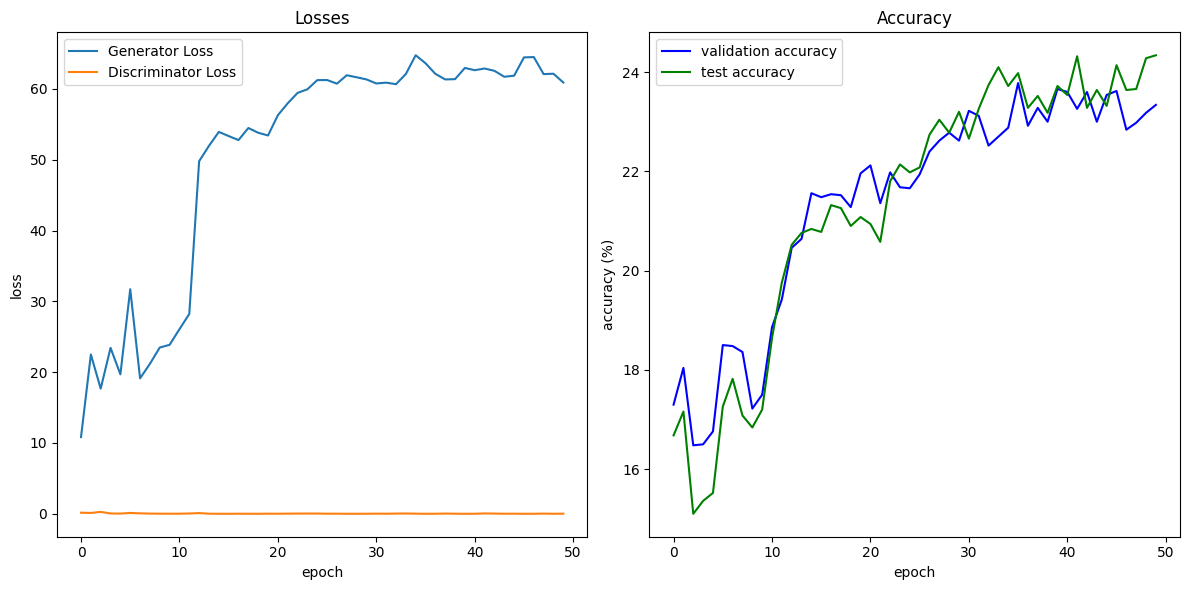

In [18]:
advgan_trainer.plot_metrics()

In [19]:
advgan_trainer.print_attack_success_rates()

Attack Success Rates Overall:
75.61%
Attack Success Rates by Class:
Class plane: 61.43%
Class car: 87.07%
Class bird: 70.98%
Class cat: 78.53%
Class deer: 71.89%
Class dog: 97.97%
Class frog: 58.87%
Class horse: 89.40%
Class ship: 55.56%
Class truck: 84.43%


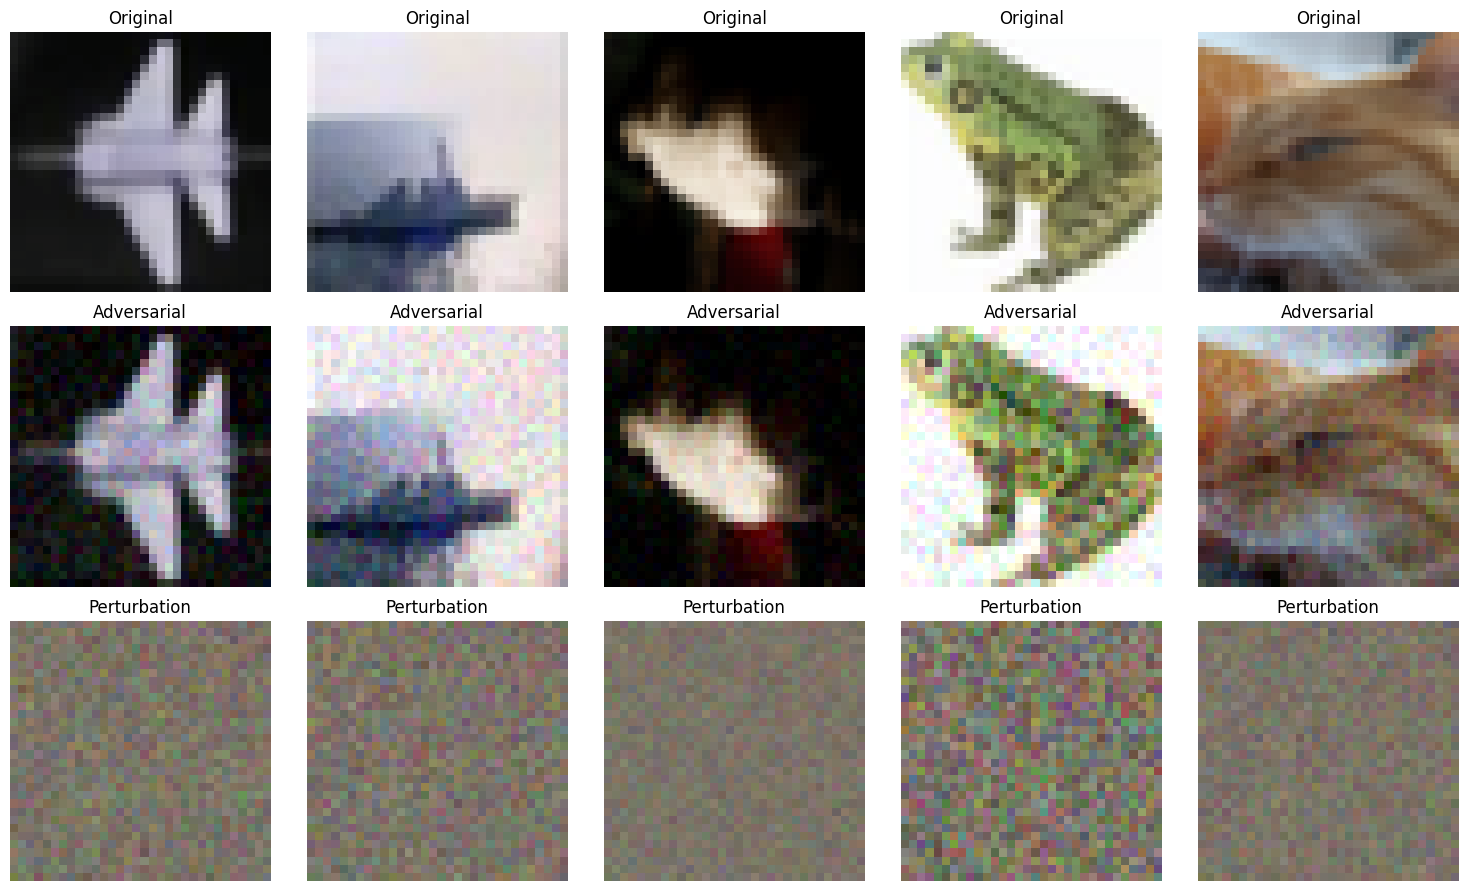

In [36]:
advgan_trainer.plot_random_images(test_loader)

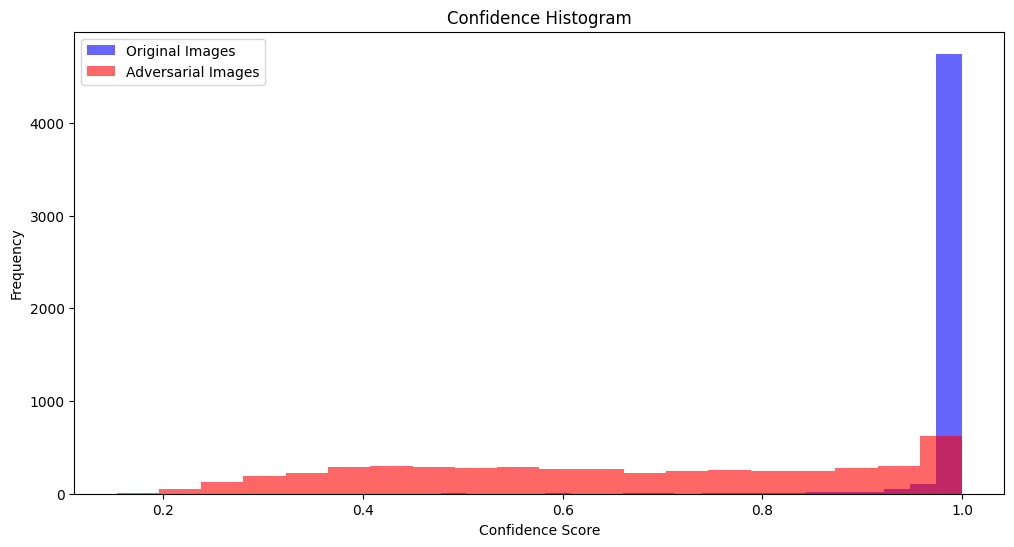

In [21]:
advgan_trainer.plot_confidence_histograms(test_loader)

---